# Practica 2 - Natural Language processing

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 537.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.2 MB/s eta 0:00:00


In [2]:
import numpy as np

import tensorflow as tf

import pandas as pd
from collections import Counter
import re

from tensorflow import keras


import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import Embedding, Dot, Reshape, Dense

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams

from keras.callbacks import TensorBoard

import re
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

import numpy as np
from tensorflow.keras.preprocessing.sequence import skipgrams

In [3]:
import gdown
import os

# Crear el directorio de datos si no existe
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# URL de Google Drive en formato correcto para gdown
url = "https://drive.google.com/uc?id=1GXSUzaXDvrlcimgTwRR9tmDr6xr8gu49"
zip_filename = "sentiment_analysis.zip"
zip_path = os.path.join(data_dir, zip_filename)

# Descargar el archivo
if not os.path.exists(zip_path):
    gdown.download(url, zip_path, quiet=False)
else:
    print("Data zipfile already exists")

Downloading...
From: https://drive.google.com/uc?id=1GXSUzaXDvrlcimgTwRR9tmDr6xr8gu49
To: /content/data/sentiment_analysis.zip
100%|██████████| 1.86M/1.86M [00:00<00:00, 146MB/s]


In [4]:
import shutil
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

data_dir = "data"
zip_filename = "sentiment_analysis.zip"
zip_path = os.path.join(data_dir, zip_filename)
files = ["train.csv", "test.csv"]
full_paths = [os.path.join(data_dir, file) for file in files]

if not all(os.path.isfile(path) for path in full_paths):
    with ZipFile(zip_path, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if not file.startswith("__MACOSX"):
                    exe.submit(zf.extract, file, path=data_dir)
else:
    print("test and train files already exist")

In [5]:
import os
import pandas as pd

data_dir = "data"
train_path = os.path.join(data_dir, "train.csv")
test_path = os.path.join(data_dir, "test.csv")
train_df = pd.read_csv(train_path, encoding='ISO-8859-1', index_col="textID")
test_df = pd.read_csv(test_path, encoding='ISO-8859-1', index_col="textID")
train_df.head()

,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
textID,,,,,,,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [6]:
train_df = train_df.dropna()
test_df = test_df.dropna()
text_df = pd.concat([train_df, test_df])
text_df.shape

(31014, 9)

In [7]:
from tensorflow.keras.layers import TextVectorization

vocab_size = 8_192

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    standardize="lower_and_strip_punctuation",
    split="whitespace",
)

corpus = text_df["text"].values

vectorize_layer.adapt(corpus)

vectorize_layer(corpus)

<tf.Tensor: shape=(31014, 33), dtype=int64, numpy=
array([[ 284,   17,    1, ...,    0,    0,    0],
       [ 416,  112,    2, ...,    0,    0,    0],
       [   6, 1378,   10, ...,    0,    0,    0],
       ...,
       [   2,   54,   57, ...,    0,    0,    0],
       [   1,   57,   10, ...,    0,    0,    0],
       [   1,    1, 2150, ...,    0,    0,    0]])>

In [8]:
vectorize_layer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('i'),
 np.str_('to'),
 np.str_('the'),
 np.str_('a'),
 np.str_('my'),
 np.str_('and'),
 np.str_('you'),
 np.str_('it')]

In [9]:
import tensorflow as tf

text_ds = tf.data.Dataset.from_tensor_slices(train_df["text"])

print(text_ds.element_spec)
for sentence in text_ds.take(5):
  print(sentence)

TensorSpec(shape=(), dtype=tf.string, name=None)
tf.Tensor(b' I`d have responded, if I were going', shape=(), dtype=string)
tf.Tensor(b' Sooo SAD I will miss you here in San Diego!!!', shape=(), dtype=string)
tf.Tensor(b'my boss is bullying me...', shape=(), dtype=string)
tf.Tensor(b' what interview! leave me alone', shape=(), dtype=string)
tf.Tensor(b' Sons of ****, why couldn`t they put them on the releases we already bought', shape=(), dtype=string)


In [10]:
# Apply the vectorization layer to get token sequences
vectorized_ds = text_ds.map(lambda x: vectorize_layer(x))

print(vectorized_ds.element_spec)
next(vectorized_ds.as_numpy_iterator())

TensorSpec(shape=(None,), dtype=tf.int64, name=None)


array([284,  17,   1,  68,   2, 121,  47])

In [11]:
def generate_skipgram_pairs(sequence, window_size=4):
    seq_len = tf.shape(sequence)[0]
    positions = tf.range(seq_len)

    def extract_context(i):
        target = sequence[i]
        return tf.cond(
            tf.equal(target, 0),
            lambda: tf.data.Dataset.from_tensors((tf.constant(-1, dtype=sequence.dtype),
                                                  tf.constant(-1, dtype=sequence.dtype))).take(0),
            lambda: _valid_context(i, target)
        )

    def _valid_context(i, target):
        start = tf.maximum(0, i - window_size)
        end = tf.minimum(seq_len, i + window_size + 1)

        # Exclude center word
        left = sequence[start:i]
        right = sequence[i + 1:end]
        context = tf.concat([left, right], axis=0)

        # Remove zeros
        non_zero = tf.not_equal(context, 0)
        context = tf.boolean_mask(context, non_zero)
        targets = tf.fill([tf.shape(context)[0]], target)

        return tf.data.Dataset.from_tensor_slices((targets, context))

    return tf.data.Dataset.from_tensor_slices(positions).flat_map(extract_context)

# Apply skipgram generation to each vectorized sentence
sg_ds = vectorized_ds.flat_map(lambda x: generate_skipgram_pairs(x, window_size=4))

# Optionally convert to list of tuples
print(sg_ds.element_spec)
next(sg_ds.as_numpy_iterator())

(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


(np.int64(284), np.int64(17))

In [12]:
for target_idx, context_idx in sg_ds.take(20):
  print(f"target: {vectorize_layer.get_vocabulary()[target_idx]} | context: {vectorize_layer.get_vocabulary()[context_idx]}")

target: id | context: have
target: id | context: [UNK]
target: id | context: if
target: id | context: i
target: have | context: id
target: have | context: [UNK]
target: have | context: if
target: have | context: i
target: have | context: were
target: [UNK] | context: id
target: [UNK] | context: have
target: [UNK] | context: if
target: [UNK] | context: i
target: [UNK] | context: were
target: [UNK] | context: going
target: if | context: id
target: if | context: have
target: if | context: [UNK]
target: if | context: i
target: if | context: were


In [13]:
import tensorflow as tf

text_ds = tf.data.Dataset.from_tensor_slices(train_df["text"])

print(text_ds.element_spec)
for sentence in text_ds.take(5):
  print(sentence)

TensorSpec(shape=(), dtype=tf.string, name=None)
tf.Tensor(b' I`d have responded, if I were going', shape=(), dtype=string)
tf.Tensor(b' Sooo SAD I will miss you here in San Diego!!!', shape=(), dtype=string)
tf.Tensor(b'my boss is bullying me...', shape=(), dtype=string)
tf.Tensor(b' what interview! leave me alone', shape=(), dtype=string)
tf.Tensor(b' Sons of ****, why couldn`t they put them on the releases we already bought', shape=(), dtype=string)


In [15]:
text_ds = tf.data.Dataset.from_tensor_slices(train_df["text"])

fit_ds = (
    text_ds
    .map(
        lambda x: vectorize_layer(x),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    .flat_map(
        lambda x: generate_skipgram_pairs(x, window_size=2),
    )
    # .cache()
    # .map(
    #     lambda x, y: ((x, y), tf.constant(1)),
    #     num_parallel_calls=tf.data.AUTOTUNE,
    # )
)

# lambda x: ((tf.one_hot(x[0], depth=vocab_size), tf.one_hot(x[1], depth=vocab_size)), tf.constant(1.0)),

print(fit_ds.element_spec)
next(fit_ds.as_numpy_iterator())

(TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


(np.int64(284), np.int64(17))

In [23]:
count = fit_ds.reduce(tf.constant(0), lambda x, _: x + 1).numpy()
fit_ds = fit_ds.apply(tf.data.experimental.assert_cardinality(count))

In [24]:
tf.data.experimental.cardinality(fit_ds).numpy()

np.int64(1229566)

In [26]:
fit_ds = (
    fit_ds
    .map(
        lambda x, y: ((x, y), tf.constant(1)),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
)
print(fit_ds.element_spec)
next(fit_ds.as_numpy_iterator())

(((TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(), dtype=tf.int32, name=None))


(((array([ 36, 283,   9, ...,  14, 796,  24]),
   array([900, 106,  46, ..., 139,  78,  43])),
  array([1, 1, 1, ..., 1, 1, 1], dtype=int32)),
 np.int32(1))

In [54]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dot, Activation, Flatten

# embedding_dims    = [45, 312, 752]
# window_sizes      = [2, 4]
embedding_dims = [312]
window_sizes = [4]
histories         = {}
embedding_layers  = {}
BATCH_SIZE = 1024
AUTOTUNE = tf.data.AUTOTUNE
n_epochs = 3

text_ds = tf.data.Dataset.from_tensor_slices(train_df["text"])

for w in window_sizes:
    fit_ds = (
        text_ds
        .map(
            lambda x: vectorize_layer(x),
            num_parallel_calls=AUTOTUNE,
        )
        .flat_map(
            lambda x: generate_skipgram_pairs(x, window_size=w),
        )
    )

    count = fit_ds.reduce(tf.constant(0), lambda x, _: x + 1).numpy()
    fit_ds = fit_ds.cache()
    fit_ds = fit_ds.apply(tf.data.experimental.assert_cardinality(count))

    fit_ds = (
        fit_ds
        .map(
            lambda x, y: ((x, y), tf.constant(1)),
            num_parallel_calls=AUTOTUNE,
        )
        # .cache()
        # .shuffle(len(fit_ds))
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )

    for ed in embedding_dims:
        print(f"{w=}, {ed=}")

        # Index-based input (scalar integer)
        input_target = Input(shape=(), dtype=tf.int32)
        input_context = Input(shape=(), dtype=tf.int32)

        # Shared embedding layer
        embedding_layer = Embedding(input_dim=vocab_size, output_dim=ed)

        target_embedding = embedding_layer(input_target)   # shape: (ed,)
        context_embedding = embedding_layer(input_context) # shape: (ed,)

        # If shape issues arise, flatten the embedding
        target_embedding = Flatten()(target_embedding)
        context_embedding = Flatten()(context_embedding)

        # Dot product of embeddings
        dot_product = Dot(axes=-1)([target_embedding, context_embedding])

        # Sigmoid output for skipgram-style binary prediction
        output = Activation('sigmoid')(dot_product)

        model = Model(inputs=[input_target, input_context], outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy')

        history = model.fit(fit_ds, epochs=n_epochs)

        histories[(w, ed)] = history
        embedding_layers[(w, ed)] = embedding_layer

list(histories.keys())

w=4, ed=312
Epoch 1/3
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 273s 124ms/step - loss: 0.1565
Epoch 2/3
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 265s 121ms/step - loss: 0.0012
Epoch 3/3
2194/2194 ━━━━━━━━━━━━━━━━━━━━ 256s 117ms/step - loss: 2.0512e-04


[(4, 312)]

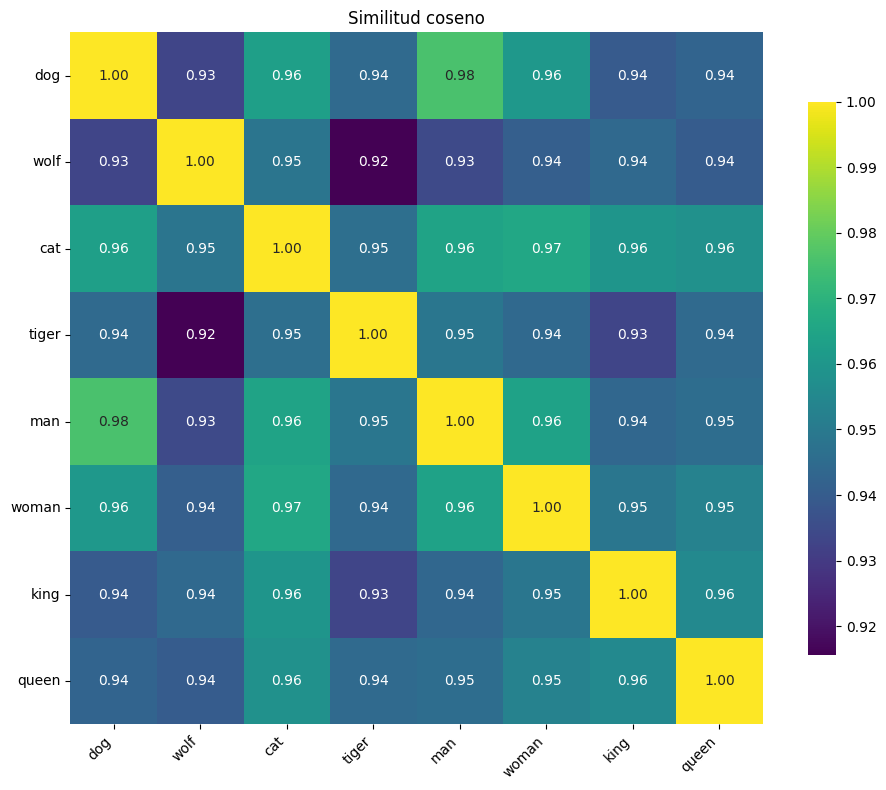

Matriz de distancias (1–coseno):


,dog,wolf,cat,tiger,man,woman,king,queen
dog,0.00,0.07,0.04,0.06,0.02,0.04,0.06,0.06
wolf,0.07,0.00,0.05,0.08,0.07,0.06,0.06,0.06
cat,0.04,0.05,0.00,0.05,0.04,0.03,0.04,0.04
tiger,0.06,0.08,0.05,0.00,0.05,0.06,0.07,0.06
man,0.02,0.07,0.04,0.05,-0.00,0.04,0.06,0.05
woman,0.04,0.06,0.03,0.06,0.04,-0.00,0.05,0.05
king,0.06,0.06,0.04,0.07,0.06,0.05,0.00,0.04
queen,0.06,0.06,0.04,0.06,0.05,0.05,0.04,0.00


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

layer_config = (4, 312)
all_indices = [488, 4889, 612, 4236, 213, 1234, 2361, 2497]

# 2) Construir la lista de palabras usando idx2word (invertido de word2idx)
# idx2word = {idx: w for w, idx in word2idx.items()}
# idx2word = dict(zip(enumerate(vectorize_layer.get_vocabulary())))
idx2word = dict(enumerate(vectorize_layer.get_vocabulary()))
words_15 = [idx2word.get(i, f"idx{i}") for i in all_indices]

# 3) Extraer la matriz de embeddings del modelo ya entrenado
emb_layer = embedding_layers[layer_config]
emb_matrix = emb_layer.get_weights()[0]        # forma = (vocab_size, embedding_dim)

# 4) Recoger los vectores para las 15 palabras
vectors_15 = []
for idx in all_indices:
    if idx < emb_matrix.shape[0]:
        vectors_15.append(emb_matrix[idx])
    else:
        vectors_15.append(np.zeros(emb_matrix.shape[1]))
vectors_15 = np.vstack(vectors_15)

# 5) Calcular similitud coseno y distancia (1–coseno)
sim_matrix = cosine_similarity(vectors_15)
dist_matrix = 1 - sim_matrix

# 6) DataFrame para visualización
df_sim  = pd.DataFrame(sim_matrix, index=words_15, columns=words_15)
df_dist = pd.DataFrame(dist_matrix, index=words_15, columns=words_15)

# 7) Heatmap de similitud (mitad inferior)
mask = np.triu(np.ones_like(df_sim, dtype=bool))
mask = None
plt.figure(figsize=(10, 8))
sns.heatmap(df_sim, mask=mask, annot=True, fmt=".2f",
            cmap="viridis", square=True, cbar_kws={'shrink':.8})
plt.title("Similitud coseno")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 8) Mostrar la matriz de distancias
print("Matriz de distancias (1–coseno):")
display(df_dist.round(2))

In [60]:
from google.colab import drive

model.save_weights('embedding_w4_d312.weights.h5')

In [44]:
fit_ds.element_spec

((TensorSpec(shape=(None,), dtype=tf.int64, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [45]:
embeddings = embedding_layer.get_weights()[0]

print(embeddings.shape)

(8192, 45)


In [49]:
# prompt: given vectorize_layer how to obtain the index for the word "what"

import numpy as np

# Get the vocabulary from the vectorize_layer
vocabulary = vectorize_layer.get_vocabulary()

word = "wolf"
# Find the index of the word
try:
    what_index = vocabulary.index(word)
    print(f"The index of {word} in the vocabulary is: {what_index}")
except ValueError:
    print(f"{word} is not found in the vocabulary.")


The index of wolf in the vocabulary is: 4889


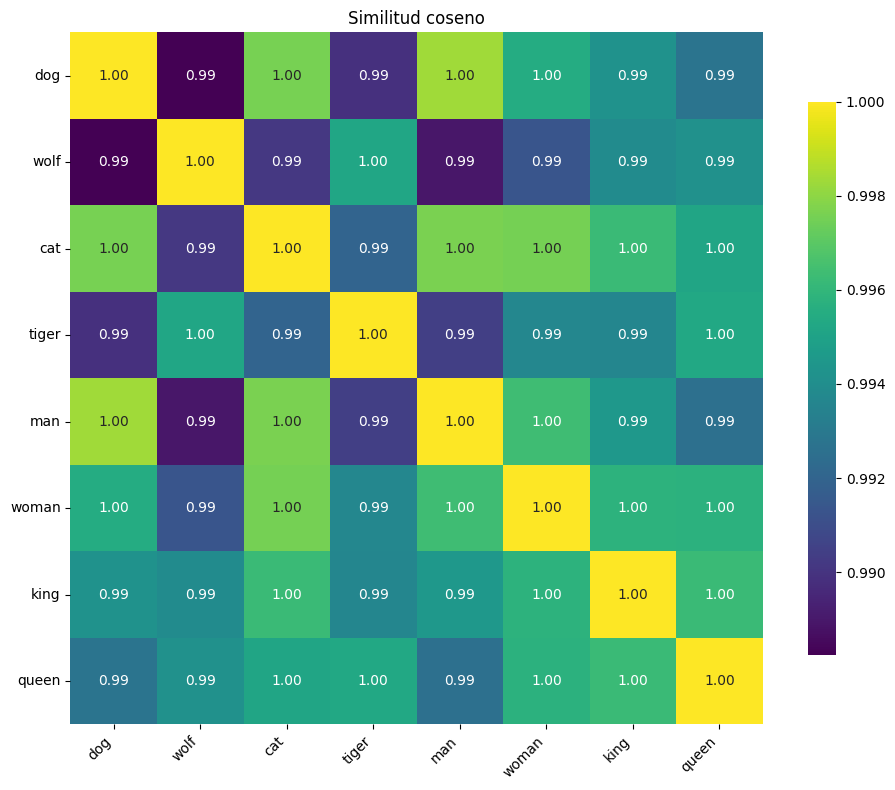

Matriz de distancias (1–coseno):


,dog,wolf,cat,tiger,man,woman,king,queen
dog,-0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.01
wolf,0.01,-0.00,0.01,0.00,0.01,0.01,0.01,0.01
cat,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00
tiger,0.01,0.00,0.01,-0.00,0.01,0.01,0.01,0.00
man,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.01
woman,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00
king,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.00
queen,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

layer_config = (2, 45)
all_indices = [488, 4889, 612, 4236, 213, 1234, 2361, 2497]

# 2) Construir la lista de palabras usando idx2word (invertido de word2idx)
# idx2word = {idx: w for w, idx in word2idx.items()}
# idx2word = dict(zip(enumerate(vectorize_layer.get_vocabulary())))
idx2word = dict(enumerate(vectorize_layer.get_vocabulary()))
words_15 = [idx2word.get(i, f"idx{i}") for i in all_indices]

# 3) Extraer la matriz de embeddings del modelo ya entrenado
emb_layer = embedding_layers[layer_config]
emb_matrix = emb_layer.get_weights()[0]        # forma = (vocab_size, embedding_dim)

# 4) Recoger los vectores para las 15 palabras
vectors_15 = []
for idx in all_indices:
    if idx < emb_matrix.shape[0]:
        vectors_15.append(emb_matrix[idx])
    else:
        vectors_15.append(np.zeros(emb_matrix.shape[1]))
vectors_15 = np.vstack(vectors_15)

# 5) Calcular similitud coseno y distancia (1–coseno)
sim_matrix = cosine_similarity(vectors_15)
dist_matrix = 1 - sim_matrix

# 6) DataFrame para visualización
df_sim  = pd.DataFrame(sim_matrix, index=words_15, columns=words_15)
df_dist = pd.DataFrame(dist_matrix, index=words_15, columns=words_15)

# 7) Heatmap de similitud (mitad inferior)
mask = np.triu(np.ones_like(df_sim, dtype=bool))
mask = None
plt.figure(figsize=(10, 8))
sns.heatmap(df_sim, mask=mask, annot=True, fmt=".2f",
            cmap="viridis", square=True, cbar_kws={'shrink':.8})
plt.title("Similitud coseno")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 8) Mostrar la matriz de distancias
print("Matriz de distancias (1–coseno):")
display(df_dist.round(2))

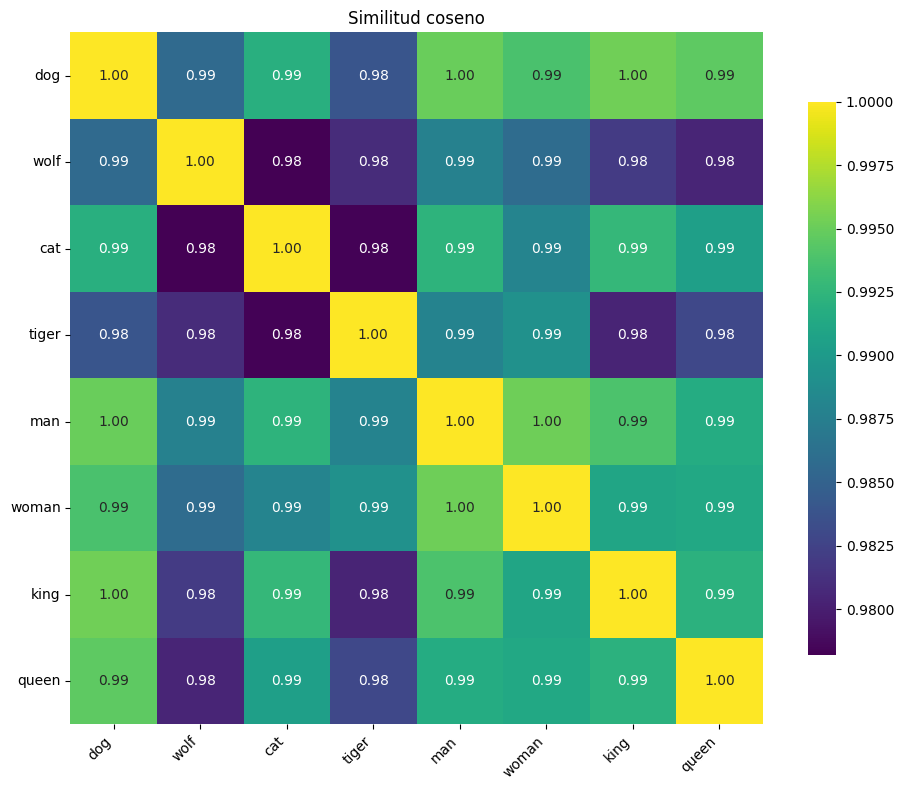

Matriz de distancias (1–coseno):


,dog,wolf,cat,tiger,man,woman,king,queen
dog,-0.00,0.01,0.01,0.02,0.00,0.01,0.00,0.01
wolf,0.01,0.00,0.02,0.02,0.01,0.01,0.02,0.02
cat,0.01,0.02,0.00,0.02,0.01,0.01,0.01,0.01
tiger,0.02,0.02,0.02,0.00,0.01,0.01,0.02,0.02
man,0.00,0.01,0.01,0.01,0.00,0.00,0.01,0.01
woman,0.01,0.01,0.01,0.01,0.00,0.00,0.01,0.01
king,0.00,0.02,0.01,0.02,0.01,0.01,0.00,0.01
queen,0.01,0.02,0.01,0.02,0.01,0.01,0.01,0.00


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

layer_config = (2, 45)
all_indices = [488, 4889, 612, 4236, 213, 1234, 2361, 2497]

# 2) Construir la lista de palabras usando idx2word (invertido de word2idx)
# idx2word = {idx: w for w, idx in word2idx.items()}
# idx2word = dict(zip(enumerate(vectorize_layer.get_vocabulary())))
idx2word = dict(enumerate(vectorize_layer.get_vocabulary()))
words_15 = [idx2word.get(i, f"idx{i}") for i in all_indices]

# 3) Extraer la matriz de embeddings del modelo ya entrenado
emb_layer = embedding_layers[layer_config]
emb_matrix = emb_layer.get_weights()[0]        # forma = (vocab_size, embedding_dim)

# 4) Recoger los vectores para las 15 palabras
vectors_15 = []
for idx in all_indices:
    if idx < emb_matrix.shape[0]:
        vectors_15.append(emb_matrix[idx])
    else:
        vectors_15.append(np.zeros(emb_matrix.shape[1]))
vectors_15 = np.vstack(vectors_15)

# 5) Calcular similitud coseno y distancia (1–coseno)
sim_matrix = cosine_similarity(vectors_15)
dist_matrix = 1 - sim_matrix

# 6) DataFrame para visualización
df_sim  = pd.DataFrame(sim_matrix, index=words_15, columns=words_15)
df_dist = pd.DataFrame(dist_matrix, index=words_15, columns=words_15)

# 7) Heatmap de similitud (mitad inferior)
mask = np.triu(np.ones_like(df_sim, dtype=bool))
mask = None
plt.figure(figsize=(10, 8))
sns.heatmap(df_sim, mask=mask, annot=True, fmt=".2f",
            cmap="viridis", square=True, cbar_kws={'shrink':.8})
plt.title("Similitud coseno")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 8) Mostrar la matriz de distancias
print("Matriz de distancias (1–coseno):")
display(df_dist.round(2))

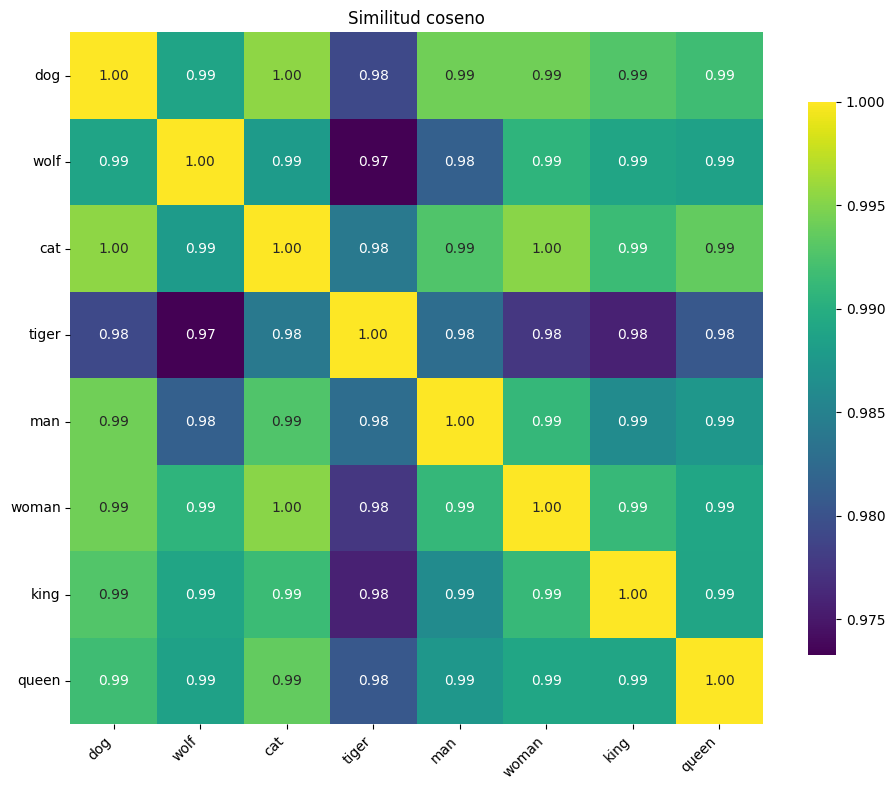

Matriz de distancias (1–coseno):


,dog,wolf,cat,tiger,man,woman,king,queen
dog,0.00,0.01,0.00,0.02,0.01,0.01,0.01,0.01
wolf,0.01,0.00,0.01,0.03,0.02,0.01,0.01,0.01
cat,0.00,0.01,0.00,0.02,0.01,0.00,0.01,0.01
tiger,0.02,0.03,0.02,-0.00,0.02,0.02,0.02,0.02
man,0.01,0.02,0.01,0.02,-0.00,0.01,0.01,0.01
woman,0.01,0.01,0.00,0.02,0.01,0.00,0.01,0.01
king,0.01,0.01,0.01,0.02,0.01,0.01,0.00,0.01
queen,0.01,0.01,0.01,0.02,0.01,0.01,0.01,-0.00


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

layer_config = (2, 45)
all_indices = [488, 4889, 612, 4236, 213, 1234, 2361, 2497]

# 2) Construir la lista de palabras usando idx2word (invertido de word2idx)
# idx2word = {idx: w for w, idx in word2idx.items()}
# idx2word = dict(zip(enumerate(vectorize_layer.get_vocabulary())))
idx2word = dict(enumerate(vectorize_layer.get_vocabulary()))
words_15 = [idx2word.get(i, f"idx{i}") for i in all_indices]

# 3) Extraer la matriz de embeddings del modelo ya entrenado
emb_layer = embedding_layers[layer_config]
emb_matrix = emb_layer.get_weights()[0]        # forma = (vocab_size, embedding_dim)

# 4) Recoger los vectores para las 15 palabras
vectors_15 = []
for idx in all_indices:
    if idx < emb_matrix.shape[0]:
        vectors_15.append(emb_matrix[idx])
    else:
        vectors_15.append(np.zeros(emb_matrix.shape[1]))
vectors_15 = np.vstack(vectors_15)

# 5) Calcular similitud coseno y distancia (1–coseno)
sim_matrix = cosine_similarity(vectors_15)
dist_matrix = 1 - sim_matrix

# 6) DataFrame para visualización
df_sim  = pd.DataFrame(sim_matrix, index=words_15, columns=words_15)
df_dist = pd.DataFrame(dist_matrix, index=words_15, columns=words_15)

# 7) Heatmap de similitud (mitad inferior)
mask = np.triu(np.ones_like(df_sim, dtype=bool))
mask = None
plt.figure(figsize=(10, 8))
sns.heatmap(df_sim, mask=mask, annot=True, fmt=".2f",
            cmap="viridis", square=True, cbar_kws={'shrink':.8})
plt.title("Similitud coseno")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 8) Mostrar la matriz de distancias
print("Matriz de distancias (1–coseno):")
display(df_dist.round(2))

In [ ]:
print(train_ds.element_spec)
next(train_ds.as_numpy_iterator())

((TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), TensorSpec(shape=(), dtype=tf.int32, name=None))


((np.int64(284), np.int64(17)), np.int32(1))

In [ ]:
classifier_train_ds = tf.data.Dataset.from_tensor_slices((vectorized_train, df_train["sentiment"].values))

print(classifier_train_ds.element_spec)
next(classifier_train_ds.as_numpy_iterator())

(TensorSpec(shape=(33,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


(array([  293,    17, 15185,    69,     2,   120,    47,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 b'neutral')

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=embeddings.shape[0],
    output_dim=embeddings.shape[1],
    weights=[embeddings],
    trainable=False
)

def embed_and_flatten(indices, label):
    embedded = embedding_layer(indices)        # shape: (seq_len, embed_dim)
    flat = tf.reshape(embedded, [-1])          # shape: (seq_len * embed_dim,)
    return flat, label

In [ ]:
classifier_train_ds = classifier_train_ds.map(embed_and_flatten)
print(classifier_train_ds.element_spec)
next(classifier_train_ds.as_numpy_iterator())

(TensorSpec(shape=(4224,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


(array([-0.17132318, -0.15126888, -0.17530611, ...,  0.4272256 ,
        -0.41871053, -0.40135565], dtype=float32),
 b'neutral')

In [ ]:
# Define a lookup table to convert string → integer
label_lookup = tf.keras.layers.StringLookup(
    vocabulary=df_train["sentiment"].unique().tolist(),
    num_oov_indices=0,
)

# Optional: one-hot encode
num_classes = label_lookup.vocabulary_size()

classifier_train_ds = classifier_train_ds.map(lambda x, y: (x, tf.one_hot(label_lookup(y), depth=num_classes)))

print(classifier_train_ds.element_spec)
next(classifier_train_ds.as_numpy_iterator())

(TensorSpec(shape=(4224,), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))


(array([-0.17132318, -0.15126888, -0.17530611, ...,  0.4272256 ,
        -0.41871053, -0.40135565], dtype=float32),
 array([1., 0., 0.], dtype=float32))

In [ ]:
classifier_train_ds = classifier_train_ds.batch(128)